# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [ ]:
df = pd.read_csv('churn.csv')
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


In [ ]:
df.shape

(7023, 12)

In [ ]:
df.dtypes.value_counts()

,count
object,8
float64,4


# Data Preprocessing

## Handling Missing Values

In [ ]:
missing_values = df.isna().sum()
missing_pct = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_pct.round(2)
})
missing_df

,Missing Count,Missing Percentage
customerID,9,0.13
Gender,16,0.23
SeniorCitizen,12,0.17
Partner,16,0.23
Dependents,19,0.27
Tenure,17,0.24
Contract,13,0.18
PaperlessBilling,13,0.18
PaymentMethod,11,0.16
MonthlyCharges,10,0.14


In [ ]:
df = df.dropna(subset=['customerID'])

In [ ]:
categorical_cols = ['Gender', 'Partner', 'Dependents', 'Contract',
                       'PaperlessBilling', 'PaymentMethod']

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
      mode_value = df[col].mode()[0]
      df[col].fillna(mode_value, inplace=True)

In [ ]:
numerical_cols = ['SeniorCitizen', 'Tenure', 'MonthlyCharges']

for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)

In [ ]:
df.isna().sum()

,0
customerID,0
Gender,0
SeniorCitizen,0
Partner,0
Dependents,0
Tenure,0
Contract,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0


## Handling Duplicates

In [ ]:
df.duplicated().sum()

np.int64(14)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

np.int64(0)

# EDA

## Target Variable Analysis & Demographic Analysis

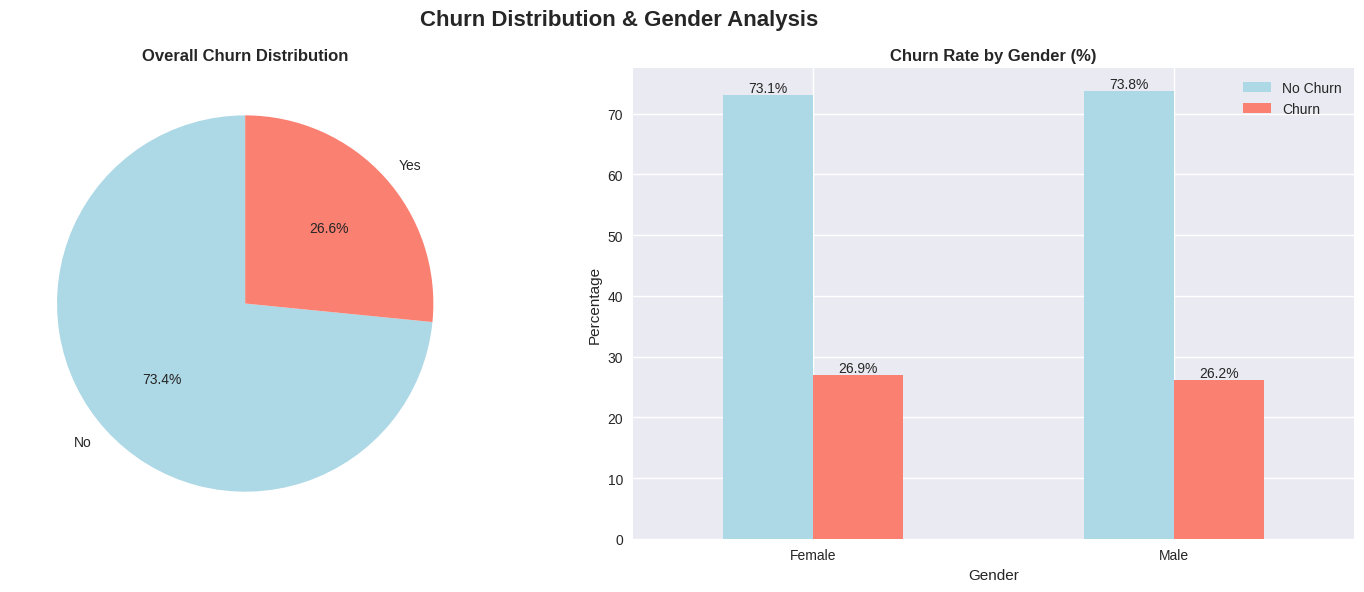

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Churn Distribution & Gender Analysis', fontsize=16, fontweight='bold')

# Plot 1: Churn distribution
churn_counts = df['Churn'].value_counts()
wedges, texts, autotexts = axes[0].pie(churn_counts.values,
                                      labels=churn_counts.index,
                                      autopct='%1.1f%%',
                                      colors=['lightblue', 'salmon'],
                                      startangle=90)
axes[0].set_title('Overall Churn Distribution', fontsize=12, fontweight='bold')

# Plot 2: Churn by Gender with percentages
churn_gender = pd.crosstab(df['Gender'], df['Churn'], normalize='index') * 100
bars = churn_gender.plot(kind='bar', ax=axes[1], color=['lightblue', 'salmon'])
axes[1].set_title('Churn Rate by Gender (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage')
axes[1].legend(['No Churn', 'Churn'])
axes[1].tick_params(axis='x', rotation=0)

# Add percentage labels on bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.show()

## Financial & Tenure Analysis

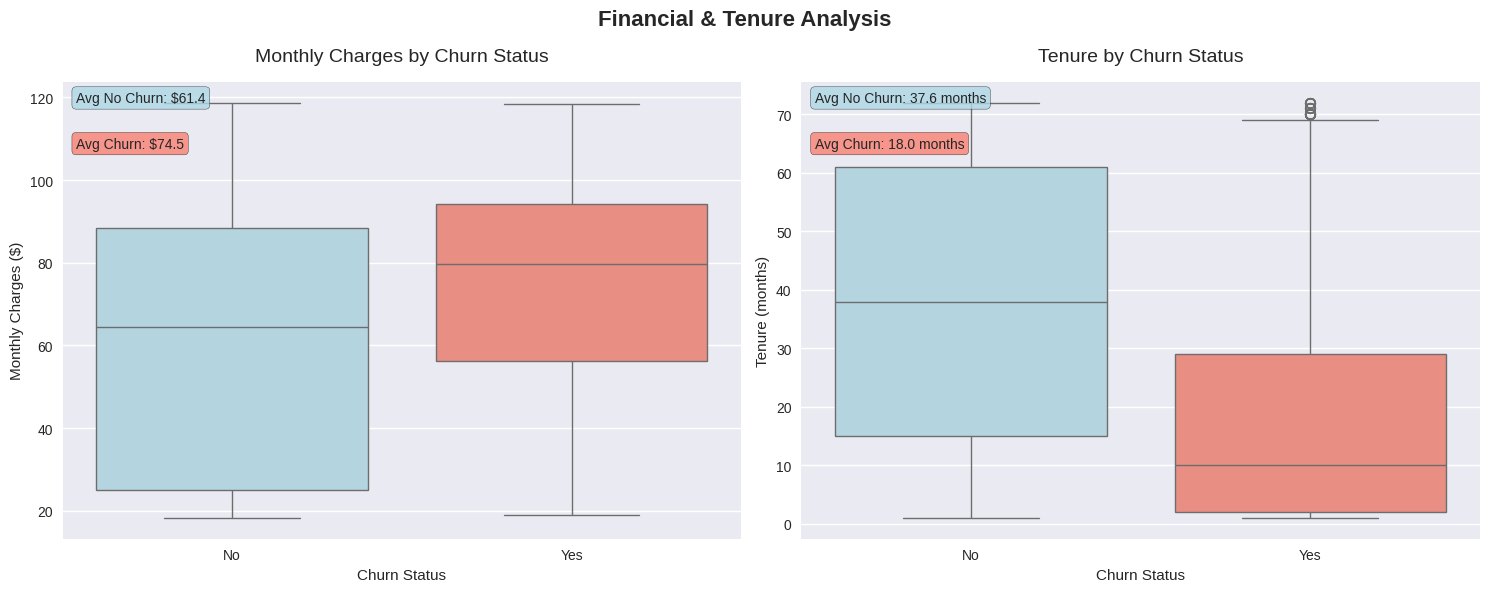

In [ ]:
plt.figure(figsize=(15, 6))
plt.suptitle('Financial & Tenure Analysis', fontsize=16, fontweight='bold')

# Plot 1: Monthly Charges
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=['lightblue', 'salmon'])
plt.title('Monthly Charges by Churn Status', fontsize=14, pad=15)
plt.xlabel('Churn Status')
plt.ylabel('Monthly Charges ($)')

# mean annotations
churn_yes_charges = df[df['Churn'] == 'Yes']['MonthlyCharges'].mean()
churn_no_charges = df[df['Churn'] == 'No']['MonthlyCharges'].mean()

ax1.text(0.02, 0.98, f'Avg No Churn: ${churn_no_charges:.1f}',
        transform=ax1.transAxes, va='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax1.text(0.02, 0.88, f'Avg Churn: ${churn_yes_charges:.1f}',
        transform=ax1.transAxes, va='top',
        bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.8))

# Plot 2: Tenure
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(data=df, x='Churn', y='Tenure', palette=['lightblue', 'salmon'])
plt.title('Tenure by Churn Status', fontsize=14, pad=15)
plt.xlabel('Churn Status')
plt.ylabel('Tenure (months)')

# mean annotations
churn_yes_tenure = df[df['Churn'] == 'Yes']['Tenure'].mean()
churn_no_tenure = df[df['Churn'] == 'No']['Tenure'].mean()

ax2.text(0.02, 0.98, f'Avg No Churn: {churn_no_tenure:.1f} months',
        transform=ax2.transAxes, va='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax2.text(0.02, 0.88, f'Avg Churn: {churn_yes_tenure:.1f} months',
        transform=ax2.transAxes, va='top',
        bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.8))

plt.tight_layout()
plt.show()

# Data Preparation

## Feature-Target Separation

In [ ]:
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

## Encoding Target

In [ ]:
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

Target encoding: {'No': np.int64(0), 'Yes': np.int64(1)}


## Train-Validation-Test Split

Train-Test Split (80-20)

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Train-Validation Split (75-25)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [ ]:
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

Training set: 4213 samples (60.0%)
Validation set: 1405 samples (20.0%)
Test set: 1405 samples (20.0%)


Stratifikasi Distribusi Kelas di Tiap Subset

In [ ]:
print(f"Train - No Churn: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%), Churn: {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")
print(f"Val - No Churn: {(y_val==0).sum()} ({(y_val==0).mean()*100:.1f}%), Churn: {(y_val==1).sum()} ({(y_val==1).mean()*100:.1f}%)")
print(f"Test - No Churn: {(y_test==0).sum()} ({(y_test==0).mean()*100:.1f}%), Churn: {(y_test==1).sum()} ({(y_test==1).mean()*100:.1f}%)")


Train - No Churn: 3093 (73.4%), Churn: 1120 (26.6%)
Val - No Churn: 1032 (73.5%), Churn: 373 (26.5%)
Test - No Churn: 1032 (73.5%), Churn: 373 (26.5%)


# Feature Analysis

## Feature Identification

In [ ]:
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Numerical features (4): ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features (6): ['Gender', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## Correlation Analysis

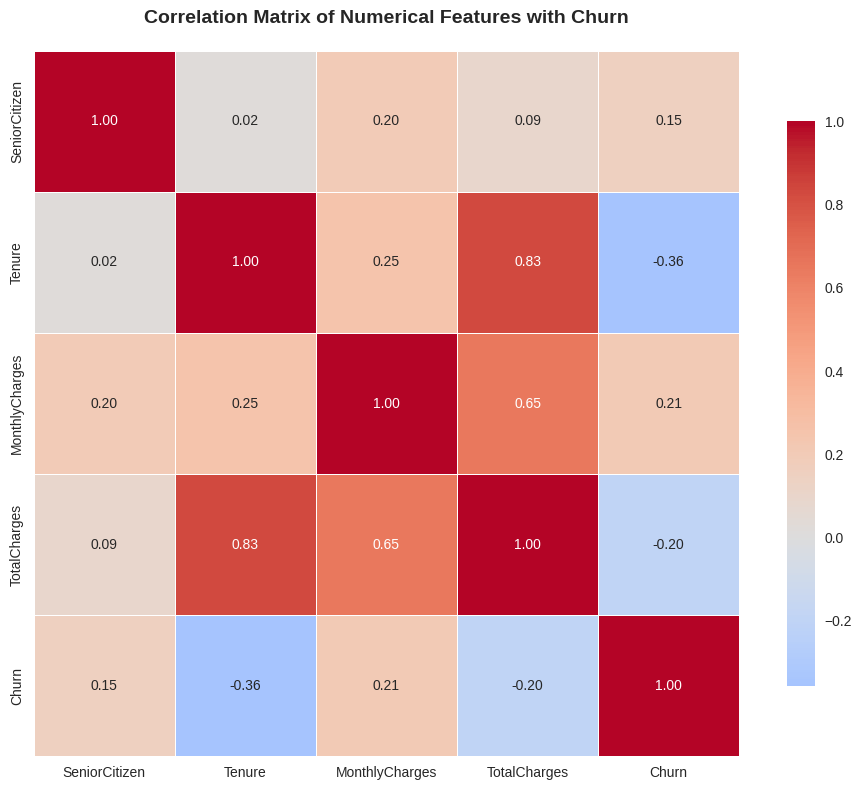

In [ ]:
corr_df = X_train[numerical_features].copy()
corr_df['Churn'] = y_train
correlation_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    fmt='.2f',
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Matrix of Numerical Features with Churn',
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Categorical Features Analysis

In [ ]:
for feature in categorical_features:
    unique_count = X_train[feature].nunique()
    print(f"{feature}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"  Values: {X_train[feature].unique().tolist()}")
    print(f"  Most common: {X_train[feature].mode().iloc[0]}")

Gender: 2 unique values
  Values: ['Male', 'Female']
  Most common: Male
Partner: 2 unique values
  Values: ['No', 'Yes']
  Most common: No
Dependents: 2 unique values
  Values: ['No', 'Yes']
  Most common: No
Contract: 3 unique values
  Values: ['Month-to-month', 'Two year', 'One year']
  Most common: Month-to-month
PaperlessBilling: 2 unique values
  Values: ['Yes', 'No']
  Most common: Yes
PaymentMethod: 4 unique values
  Values: ['Credit card (automatic)', 'Electronic check', 'Mailed check', 'Bank transfer (automatic)']
  Most common: Electronic check


# Feature Engineering

## Label Encoding

In [ ]:
binary_features = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling']
binary_encoders = {}

print("Binary Feature Encoding:")
for feature in binary_features:
    le = LabelEncoder()
    X_train[feature] = le.fit_transform(X_train[feature])
    X_val[feature] = le.transform(X_val[feature])
    X_test[feature] = le.transform(X_test[feature])
    binary_encoders[feature] = le
    print(f"{feature}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Binary Feature Encoding:
Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Partner: {'No': np.int64(0), 'Yes': np.int64(1)}
Dependents: {'No': np.int64(0), 'Yes': np.int64(1)}
PaperlessBilling: {'No': np.int64(0), 'Yes': np.int64(1)}


## One-Hot Encoding Features

In [ ]:
onehot_features = ['Contract', 'PaymentMethod']

print("\One-Hot Encoding Features:")
print(f"Features to one-hot encode: {onehot_features}")

\One-Hot Encoding Features:
Features to one-hot encode: ['Contract', 'PaymentMethod']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_binary', 'passthrough', binary_features),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), onehot_features)
    ],
    remainder='drop'
)

# Modelling

## EVALUATION METRICS SELECTION

In [ ]:
churn_rate = (y_train == 1).mean()
print(f"Training set churn rate: {churn_rate:.3f}")

if churn_rate < 0.3 or churn_rate > 0.7:
    print("Dataset shows class imbalance. Selected metrics:")
    print("- Precision: Focus on reducing false positives")
    print("- Recall: Focus on capturing actual churners")
    print("- F1-Score: Balance between precision and recall")
    print("- ROC-AUC: Overall discrimination ability")
    primary_metric = 'roc_auc'
else:
    print("Dataset is relatively balanced. Selected metrics:")
    print("- Accuracy: Overall correctness")
    print("- F1-Score: Balance between precision and recall")
    print("- ROC-AUC: Overall discrimination ability")
    primary_metric = 'f1'

print(f"Primary metric for hyperparameter tuning: {primary_metric}")

Training set churn rate: 0.266
Dataset shows class imbalance. Selected metrics:
- Precision: Focus on reducing false positives
- Recall: Focus on capturing actual churners
- F1-Score: Balance between precision and recall
- ROC-AUC: Overall discrimination ability
Primary metric for hyperparameter tuning: roc_auc


## Model Training

In [ ]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.1, 0.2],
            'classifier__max_depth': [3, 5],
            'classifier__min_samples_split': [2, 5]
        }
    }
}

## Hyperparameter Tuning

In [ ]:
results = {}
best_models = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model_config in models.items():
    print(f"\nTraining {model_name}...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_config['model'])
    ])

    grid_search = GridSearchCV(
        pipeline,
        model_config['params'],
        cv=cv,
        scoring=primary_metric,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    results[model_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_
    }
    best_models[model_name] = grid_search.best_estimator_

    print(f"Best CV Score ({primary_metric}): {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")


Training LogisticRegression...
Best CV Score (roc_auc): 0.8453
Best Parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Training RandomForest...
Best CV Score (roc_auc): 0.8361
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Training GradientBoosting...
Best CV Score (roc_auc): 0.8402
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


# Model Evaluation

## Validation Set Performance

In [ ]:
validation_results = {}
detailed_metrics = []

for model_name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    report = classification_report(y_val, y_val_pred, target_names=['No Churn', 'Churn'], output_dict=True)
    validation_results[model_name] = {
        'roc_auc': roc_auc,
        'predictions': y_val_pred,
        'probabilities': y_val_pred_proba
    }
    detailed_metrics.append({
        'Model': model_name,
        'ROC-AUC': roc_auc,
        'Accuracy': report['accuracy'],
        'No_Churn_Precision': report['No Churn']['precision'],
        'No_Churn_Recall': report['No Churn']['recall'],
        'No_Churn_F1': report['No Churn']['f1-score'],
        'Churn_Precision': report['Churn']['precision'],
        'Churn_Recall': report['Churn']['recall'],
        'Churn_F1': report['Churn']['f1-score'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score']
    })

results_df = pd.DataFrame(detailed_metrics)
results_df.round(4)

,Model,ROC-AUC,Accuracy,No_Churn_Precision,No_Churn_Recall,No_Churn_F1,Churn_Precision,Churn_Recall,Churn_F1,Macro_Avg_F1,Weighted_Avg_F1
0,LogisticRegression,0.8198,0.7922,0.8370,0.8905,0.8629,0.6319,0.5201,0.5706,0.7167,0.7853
1,RandomForest,0.8188,0.8014,0.8341,0.9109,0.8708,0.6691,0.4987,0.5714,0.7211,0.7913
2,GradientBoosting,0.8256,0.7993,0.8384,0.9002,0.8682,0.6532,0.5201,0.5791,0.7237,0.7915


## Test Set Evaluation

In [ ]:
ranking = results_df[['Model', 'ROC-AUC', 'Churn_F1', 'Accuracy']].sort_values('ROC-AUC', ascending=False)
ranking.columns = ['Model', 'ROC-AUC', 'Churn F1-Score', 'Accuracy']
ranking['Rank'] = range(1, len(ranking) + 1)
ranking = ranking[['Rank', 'Model', 'ROC-AUC', 'Churn F1-Score', 'Accuracy']]
ranking.round(4)

,Rank,Model,ROC-AUC,Churn F1-Score,Accuracy
2,1,GradientBoosting,0.8256,0.5791,0.7993
0,2,LogisticRegression,0.8198,0.5706,0.7922
1,3,RandomForest,0.8188,0.5714,0.8014


In [ ]:
best_model_name = max(validation_results.keys(), key=lambda x: validation_results[x]['roc_auc'])
best_model = best_models[best_model_name]
print(f"\nBest Model: {best_model_name} (ROC-AUC: {validation_results[best_model_name]['roc_auc']:.4f})")


Best Model: GradientBoosting (ROC-AUC: 0.8256)


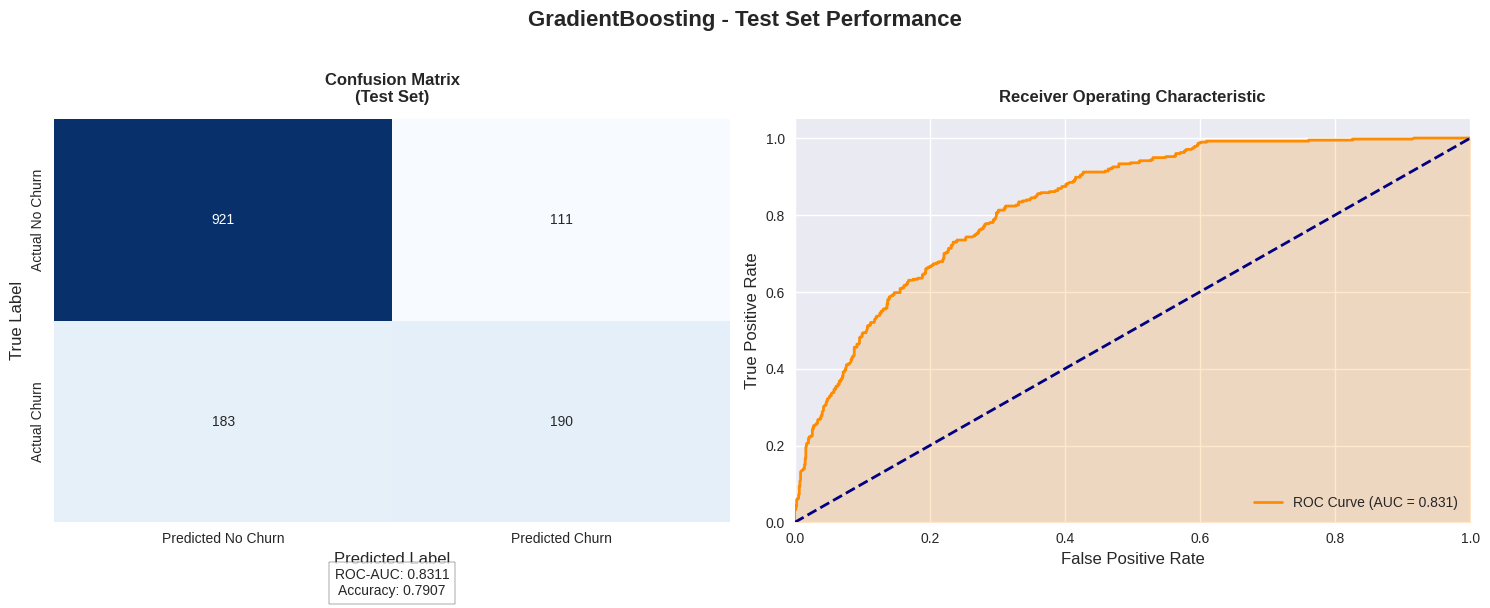

In [ ]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 6))

# 1. Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'],
            cbar=False)
plt.title(f'Confusion Matrix\n(Test Set)', fontweight='bold', pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.text(0.5, -0.15,
         f"ROC-AUC: {test_roc_auc:.4f}\nAccuracy: {accuracy_score(y_test, y_test_pred):.4f}",
         ha='center', va='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# 2. ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontweight='bold', pad=12)
plt.legend(loc="lower right")

plt.suptitle(f'{best_model_name} - Test Set Performance',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
clf_report = classification_report(y_test, y_test_pred,
                                  target_names=['No Churn', 'Churn'],
                                  output_dict=True)
clf_report_df = pd.DataFrame(clf_report).transpose()
clf_report_df.round(2)

,precision,recall,f1-score,support
No Churn,0.83,0.89,0.86,1032.00
Churn,0.63,0.51,0.56,373.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.73,0.70,0.71,1405.00
weighted avg,0.78,0.79,0.78,1405.00


## Feature Importance Analysis

In [ ]:
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_names = []
    feature_names.extend(numerical_features)
    feature_names.extend(binary_features)
    if onehot_features:
        onehot_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat_onehot']
        onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_features)
        feature_names.extend(onehot_feature_names)

    importances = best_model.named_steps['classifier'].feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(f"Top 5 features preview:")
    display(feature_importance_df.round(4))

Top 5 features preview:


,Feature,Importance
1,Tenure,0.3230
2,MonthlyCharges,0.2652
11,PaymentMethod_Electronic check,0.1159
3,TotalCharges,0.0996
9,Contract_Two year,0.0763
8,Contract_One year,0.0592
7,PaperlessBilling,0.0396
0,SeniorCitizen,0.0102
6,Dependents,0.0063
4,Gender,0.0032


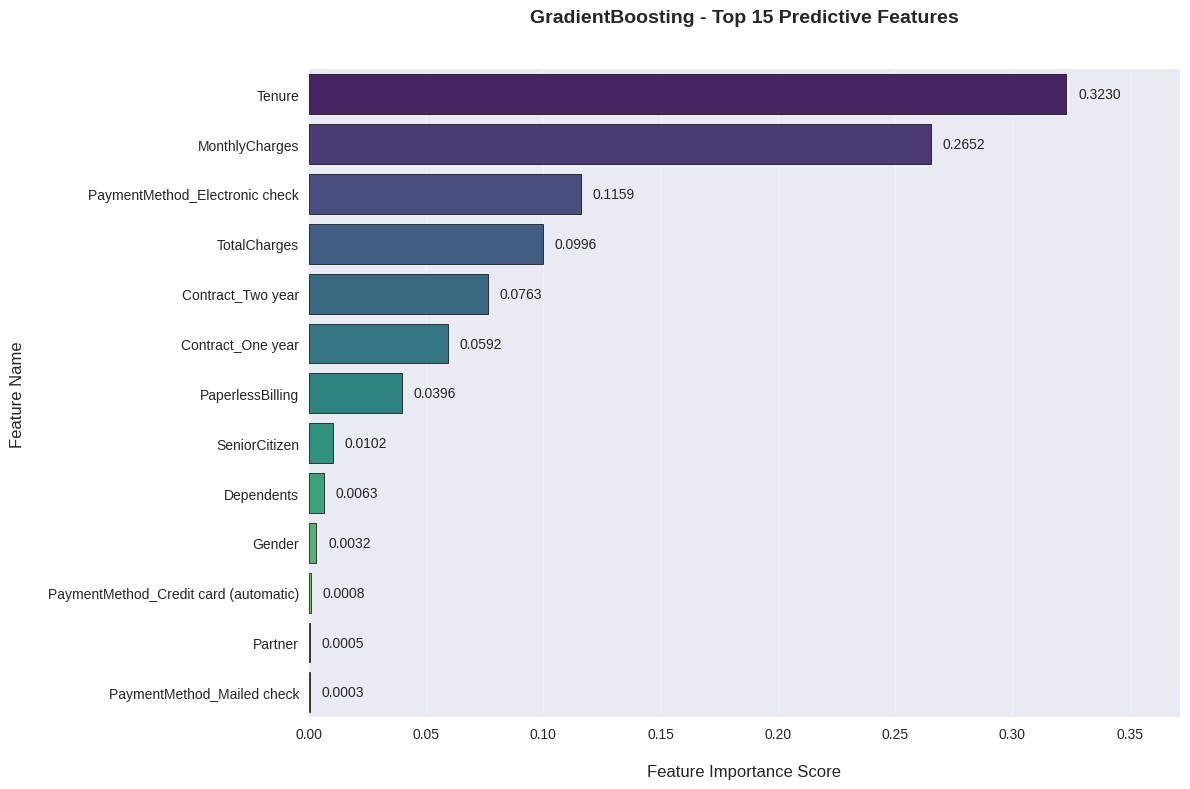

In [ ]:
if 'feature_importance_df' in locals():
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)

    ax = sns.barplot(
        data=top_features,
        y='Feature',
        x='Importance',
        palette='viridis',
        edgecolor='black',
        linewidth=0.5
    )

    for i, (_, row) in enumerate(top_features.iterrows()):
        ax.text(row['Importance'] + 0.005, i,
                f"{row['Importance']:.4f}",
                va='center',
                fontsize=10)

    plt.title(
        f'{best_model_name} - Top 15 Predictive Features\n',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    plt.xlabel('\nFeature Importance Score', fontsize=12)
    plt.ylabel('Feature Name\n', fontsize=12)
    plt.xlim([0, top_features['Importance'].max() * 1.15])
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Results and Recommendations

## Performance Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Model': list(validation_results.keys()),
    'CV_Score': [results[model]['best_score'] for model in validation_results.keys()],
    'Validation_ROC_AUC': [validation_results[model]['roc_auc'] for model in validation_results.keys()]
})

comparison_df['Test_ROC_AUC'] = ''
comparison_df.loc[comparison_df['Model'] == best_model_name, 'Test_ROC_AUC'] = f"{test_roc_auc:.4f}"

print("Model Performance Comparison:")
comparison_df

Model Performance Comparison:


,Model,CV_Score,Validation_ROC_AUC,Test_ROC_AUC
0,LogisticRegression,0.845323,0.819845,
1,RandomForest,0.836081,0.818804,
2,GradientBoosting,0.840203,0.825587,0.8311


In [ ]:
# Performance improvement analysis
baseline_accuracy = max((y_train == 0).mean(), (y_train == 1).mean())  # Majority class baseline
print(f"Baseline (majority class): {baseline_accuracy:.4f}")
print(f"Best model improvement: {test_roc_auc - 0.5:.4f} points above random (0.5)")

Baseline (majority class): 0.7342
Best model improvement: 0.3311 points above random (0.5)


## Key Findings & Model Insights

**Key Findings:**
* Dataset terdiri dari 7046 pelanggan dengan 12 fitur
* Tingkat churn: 26,6%
* Model dengan performa terbaik: Gradient Boosting
* Nilai ROC-AUC pada data final test: 0,8311

**Model Insights:**
* Fitur paling berpengaruh: Tenure (lama menjadi pelanggan)
* Model menunjukkan performa prediktif yang baik

## Business Recommendations

* Fokuskan upaya retensi pada pelanggan berisiko tinggi yang diidentifikasi oleh model
* Pantau fitur-fitur kunci yang memengaruhi prediksi churn
* Lakukan pelatihan ulang model secara berkala dengan data terbaru untuk menjaga performa
* Pertimbangkan untuk mengumpulkan fitur tambahan yang dapat meningkatkan akurasi prediksi